In [13]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from scipy.sparse.linalg import spsolve
import matplotlib.animation as animation
from scipy import sparse

In [2]:
%matplotlib inline

# Problem 1

Consider the initial/boundary value problem

\begin{align}
	\begin{split}
	&{ } u_t = 0.05 u_{xx}, \quad x \in [0,1], \quad t \in [0,1]\\
	&{ } u(0,t) = 0,\quad u(1,t) = 0,\\
	&{ } u(x,0) = 2\max\{0.2 - |x-0.5|,0\}.
	\end{split}
\end{align}

Approximate the solution $u(x,t)$ by taking 6 subintervals in the $x$ dimension and 10 subintervals in time.
Plot the approximation at $t=0, t=0.4$, and $t=1$.

In [3]:
def prob1(f,n,m,h,k,v,x):
    t = np.linspace(0,1,m+1)
    
    #calculate lambda from the parameters
    lam = v*k/(h**2)

    #create the diagonals for A
    diag1 = np.ones(n)*lam
    diag1[0] = 0
    diag2 = np.ones(n+1)*(1-2*lam)
    diag2[0], diag2[-1] = 1, 1
    diag3 = np.ones(n)*lam
    diag3[-1] = 0

    #form A from the diagonals
    A = np.diag(diag1, k=1) + np.diag(diag2) + np.diag(diag3, k=-1)

    #find U at time zero
    u0 = f(x)
    U = np.zeros((m+1, n+1))
    U[0] = u0

    #use the explicit method to find U
    for i in range(1,m+1):
        U[i] = A @ U[i-1]

    return x, U

In [17]:
#define the parameters for the problem
n = 6
m = 10
h = 1/6
k = 1/10
v = .05
x = np.linspace(0,1,n+1)
#define f
f = lambda x: 2*np.max(((.2 - np.abs(x - .5)), 0))
f = np.vectorize(f)

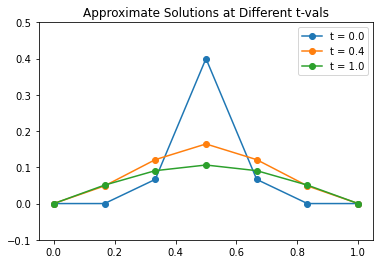

In [18]:
t = np.linspace(0,1,m+1)
x, U = prob1(f,n,m,h,k,v,x)

#plot the soln
plt.plot(x,U[0],marker='o', label = 't = '+str(t[0]))
plt.plot(x,U[4], marker='o', label = 't = '+str(t[4]))
plt.plot(x,U[-1], marker='o', label = 't = '+str(t[-1]))
plt.ylim([-.1,.5])
plt.legend()
plt.title("Approximate Solutions at Different t-vals")
plt.show()

# Problem 2

Solve the initial/boundary value problem

\begin{align}
	\begin{split}
	&{ } u_t = u_{xx}, \quad x \in [-12,12],\quad t \in [0,1], \\
	&{ } u(-12,t) = 0,\quad u(12,t) = 0,\\
	&{ } u(x,0) = \max\{1 - x^2,0\}
	\end{split}
\end{align}

using the first order explicit method (1.1).
Use 140 subintervals in the $x$ dimension and 70 subintervals in time.
The initial and final states are shown in Figures 1 and 2.
Animate your results.

Explicit methods usually have a stability condition, called a CFL condition (for Courant-Friedrichs-Lewy).
For method (1.1) the CFL condition that must be satisfied is that:

$$\lambda \leq \frac{1}{2}$$

Repeat your computations using 140 subintervals in the $x$ dimension and 66 subintervals in time. Animate the results.
For these values the CFL condition is broken; you should easily see the result of this instability in the approximation $U^{66}$.


In [6]:
#define our parameters
n = 140
m = 70
x = np.linspace(-12,12,n+1)
t = np.linspace(0,1,m+1)
h = 24/n
k = 1/m
v = 1
#define f
def f(x):
    return np.where(1-x**2 > 0, 1 - x**2, 0)

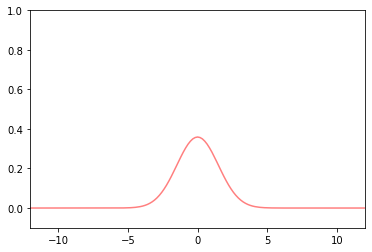

In [7]:
x,U = prob1(f,n,m,h,k,v,x)

#animate the rows (time solutions) of U
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim((-12,12))
ax.set_ylim((-.1,1))
traj, = plt.plot([], [], color = 'r', alpha=.5)
def update(i):
    traj.set_data(x,U[i])    #create our update function
    return traj
    
wave_anime = animation.FuncAnimation(fig, update, frames=range(m), interval=100)
wave_anime.save("heat_equation1.mp4")

<video src="heat_equation1.mp4" controls>

In [8]:
#define our parameters (use different time step)
n = 140
m = 66
x = np.linspace(-12,12,n+1)
t = np.linspace(0,1,m+1)
h = 24/n
k = 1/m
v = 1

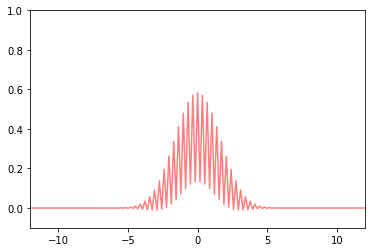

In [9]:
x,U = prob1(f,n,m,h,k,v,x)

#animate the rows (time solutions) of U
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim((-12,12))
ax.set_ylim((-.1,1))
traj, = plt.plot([], [], color = 'r', alpha=.5)
def update(i):
    traj.set_data(x,U[i])    #create our update function
    return traj
    
wave_anime = animation.FuncAnimation(fig, update, frames=range(m), interval=100)
wave_anime.save("heat_equation2.mp4")

<video src="heat_equation2.mp4" controls>

# Problem 3

Using the Crank Nicolson method, numerically approximate the solution $u(x,t)$ of the problem
\begin{align}
	\begin{split}
	&{ } u_t = u_{xx}, \quad x \in [-12,12],\quad t \in [0,1],\\
	&{ } u(-12,t) = 0,\quad u(12,t) = 0,\\
	&{ } u(x,0) = \max\{1 - x^2,0\}.
	\end{split}
\end{align}
Note that this is an implicit linear scheme; hence, the most efficient way to find $U^{j+1}$ is to create the matrix $B$ as a sparse matrix and then use \li{scipy.sparse.linalg.solve}.

Demonstrate that the numerical approximation at $t = 1$ converges.
Do this by computing $U$ at $t=1$ using $20,40,80,160,320$, and $640$ steps.
Use the same number of steps in both time and space.
Reproduce the loglog plot shown in the lab.
The slope of the line there shows the order of convergence.

To measure the error, use the solution with the smallest $h$ (largest number of intervals) as if it were the exact solution, then sample each solution only at the x-values that are represented in the solution with the largest $h$ (smallest number of intervals).
Use the $\infty$-norm on the arrays of values at those points to measure the error.

Notice that, since the Crank-Nicolson method is unconditionally stable, there is no CFL condition, and we can safely use the same number of intervals in time and space.

In [10]:
def heat_cn(nu,f,xbounds,tbounds,xsteps,tsteps):
    """Computes the Crank-Nicholson solution to the heat equation initial/boundary
    value problem:
    
        u_t = νu_xx, x∈[x0,x1] t∈[t0,t1]
        u(x0,t) = 0, u(x1,t) = 0
        u(x,0) = f(x)
    """
    #define our parameters
    n = xsteps
    m = tsteps
    x = np.linspace(xbounds[0],xbounds[1],n+1)
    t = np.linspace(tbounds[0],tbounds[1],m+1)
    h = (xbounds[1]-xbounds[0])/n
    k = (tbounds[1]-tbounds[0])/m
    v = nu
    
    #calculate lambda from our parameters
    lam = v*k/(2*h**2)
    
    #create the diagonals for A
    diag1 = np.ones(n)*lam
    diag1[0] = 0
    diag2 = np.ones(n+1)*(1-2*lam)
    diag2[0], diag2[-1] = 1, 1
    diag3 = np.ones(n)*lam
    diag3[-1] = 0
    
    #create sparse A from diagonals
    A = np.diag(diag1, k=1) + np.diag(diag2) + np.diag(diag3, k=-1)
    A = sparse.csr_matrix(A)
    
    diag1 = np.ones(n)*-lam
    diag1[0] = 0
    diag2 = np.ones(n+1)*(1+2*lam)
    diag2[0], diag2[-1] = 1, 1
    diag3 = np.ones(n)*-lam
    diag3[-1] = 0
    
    #create B from diagonals
    B = np.diag(diag1, k=1) + np.diag(diag2) + np.diag(diag3, k=-1)
    
    #find the solution at t=0
    u0 = f(x)
    U = np.zeros((m+1, n+1))
    U[0] = u0
    
    #find the solution for all values of t
    for i in range(1,m+1):
        U[i] = spsolve(B, A@U[i-1])
    
    return U

In [11]:
#define the parameters for this problem
nu = 1
def f(x):
    return np.where(1-x**2 > 0, 1 - x**2, 0)
xbounds = [-12,12]
tbounds = [0,1]
approx = []

In [14]:
#calculate the approximations for each stepsize only at the locations of largest step size
for interval in [(1,20), (2,40), (4,80), (8,160), (16,320), (32,640)]:
    vals = interval[0]*np.arange(21)
    xsteps, tsteps = interval[1], interval[1]
    U = heat_cn(nu,f,xbounds,tbounds,xsteps,tsteps)
    approx.append(U[-1][vals])

#treat the smallest step size as true solution
soln = approx[-1]
#find the error of each stepsize
errors = [np.max(np.abs(soln - ap)) for ap in approx[:-1]]

#calculate the stepsize and stepsize squared for each case
hs = [((xbounds[1]-xbounds[0])/n) for n in [20, 40, 80, 160, 320]]
hsquared = [h**2 for h in hs]

C:\Users\bryan\anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


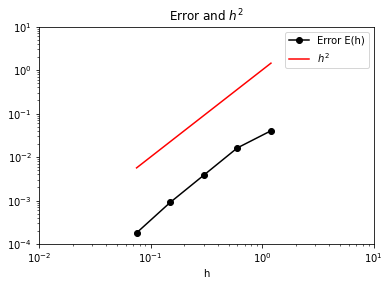

In [21]:
#plot the error and h squared on log scale
plt.loglog(hs, errors, color='black', marker='o', label="Error E(h)")
plt.loglog(hs, hsquared, color='r', label='$h^2$')

plt.legend()
plt.ylim(10e-5, 10)
plt.xlim(10e-3, 10)
plt.xlabel('h')
plt.title("Error and $h^2$")
plt.show()